In [35]:
import definitions as df
import data_manipulation as dm
import norm_def as nd
import torch
import matplotlib.pyplot as plt
import model as md
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import sql_def as sql
import os

In [36]:
# path_to_database = r"./data"
# path_to_code = r"./"
# os.chdir(path_to_database)
# track_from_sql =  sql.data_from_sql("database.db", "SELECT * FROM TRACKMATEDATA")
# os.chdir(path_to_code)
# track_with_frame = df.separate_trajectories(track_from_sql)
# trajectories1 = df.separate_data(track_with_frame, False)
# trajectories = []
# for temp in trajectories1:
#     f2 = []
#     c = 1
#     for t1 in temp:
#         f2.append(t1)
#         c += 1
#         if c == 10:
#             break
#     trajectories.append(f2)
# trajectories

In [53]:
total_size = 12000
max_x = 1000
max_y = 1000
min_x = 0
min_y = 0
track_len = 20

trajectories = dm.create_synthetic(total_size, max_x, max_y, min_x, min_y, track_len)

train_norm, val_norm, test_norm = df.split_data(trajectories, train_percent=60, val_percent=10)
train, min_x, min_y, range_x, range_y = nd.normalize_data(train_norm)
val, _, _, _, _ = nd.normalize_data(val_norm, min_x, min_y, range_x, range_y)
test, _, _, _, _ = nd.normalize_data(test_norm, min_x, min_y, range_x, range_y)

# Mask the point at index 6
train_data, train_masked_point = df.mask_point_at_index(train, 10)
val_data, val_masked_point = df.mask_point_at_index(val, 10)
test_data, test_masked_point = df.mask_point_at_index(test, 10)

# Prepare the data tensors
src_data_tensor, tgt_data_tensor, src_masks_tensor = df.prepare_data_for_transformer(train_data, train_masked_point)
val_src_data_tensor, val_tgt_data_tensor, val_src_masks_tensor = df.prepare_data_for_transformer(val_data, val_masked_point)
test_src_data_tensor, test_tgt_data_tensor, test_src_masks_tensor = df.prepare_data_for_transformer(test_data, test_masked_point)
print(src_masks_tensor)

hello
hello
hello
tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


In [54]:
def calculate_accuracy_with_tolerance(data, tg, bp, tolerance=10):
    correct = 0
    total = 0

    for i, (seq, mask_seq, target_seq) in enumerate(zip(data, bp, tg)):
        target_index = 0
        for j, (mask, pred) in enumerate(zip(mask_seq, seq)):
            if mask:
                if target_index < len(target_seq):
                    target = target_seq
                    total += 1
                    if abs(pred[0] - target[0]) <= tolerance and abs(pred[1] - target[1]) <= tolerance:
                        correct += 1
                    target_index += 1
                else:
                    print("Warning")
    if total == 0:
        return 0  # Avoid division by zero
    accuracy = (correct / total) * 100
    return accuracy


In [55]:
import math

def calculate_accuracy_with_distance(data, tg, bp, tolerance=10):
    correct = 0
    total = 0

    for i, (seq, mask_seq, target_seq) in enumerate(zip(data, bp, tg)):
        target_index = 0
        for j, (mask, pred) in enumerate(zip(mask_seq, seq)):
            if mask:
                if target_index < len(target_seq):
                    target = target_seq[target_index]
                    total += 1
                    if isinstance(pred, float): 
                        pred = [pred, pred]
                    if isinstance(target, float):
                        target = [target, target] 
                    distance = math.sqrt((pred[0] - target[0]) ** 2 + (pred[1] - target[1]) ** 2)
                    if distance <= tolerance:
                        correct += 1
                    target_index += 1
                else:
                    print("Warning")

    if total == 0:
        return 0
    accuracy = (correct / total) * 100
    return accuracy


In [56]:
def create_optimized_edge_index(num_points, connectivity_range=2):
    row = []
    col = []
    weights = []
    
    for i in range(num_points):
        for j in range(max(0, i-connectivity_range), min(num_points, i+connectivity_range+1)):
            if i != j:
                row.append(i)
                col.append(j)
                weight = 1 / abs(i - j)
                weights.append(weight)

    edge_index = torch.tensor([row, col], dtype=torch.long)
    edge_weight = torch.tensor(weights, dtype=torch.float)
    return edge_index, edge_weight

edge_index, edge_weight = create_optimized_edge_index(5, 5);
print(edge_index)
print(edge_weight)

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4],
        [1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3]])
tensor([1.0000, 0.5000, 0.3333, 0.2500, 1.0000, 1.0000, 0.5000, 0.3333, 0.5000,
        1.0000, 1.0000, 0.5000, 0.3333, 0.5000, 1.0000, 1.0000, 0.2500, 0.3333,
        0.5000, 1.0000])


In [57]:
edge_index, edge_weights = create_optimized_edge_index(20, 7)
print(edge_index)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,
          5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
          8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
          9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
         11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15,
         15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
         18, 19, 19, 19, 19,

In [58]:
x = nd.unnormalize_point((0.13, 0.14), min_x, min_y, range_x, range_y)
nd.unnormalize_point((0,0),  min_x, min_y, range_x, range_y)

(-184.739612, -184.848044)

In [59]:
# import torch.optim.lr_scheduler as lr_scheduler


# src_data_tensor, tgt_data_tensor, src_masks_tensor = df.prepare_data_for_transformer(train_data, train_masked_point)

# ## DEBUG


# input_dim = 2
# hidden_dim = 64                                                                                   
# output_dim = 2
# rate = 0.0001
# val_loss_values = []
# #model = md.SelfSupervisedModel(in_channels=3, out_channels=128, input_dim=128, model_dim=256, num_heads=8, num_layers=6, output_dim=3)
# model = md.LSTMModel(2, 32, 2, 1)
# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=rate) ## w
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True)


# dataset = TensorDataset(src_data_tensor, tgt_data_tensor, src_masks_tensor)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# val_dataset = TensorDataset(val_src_data_tensor, val_tgt_data_tensor, val_src_masks_tensor)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ## TEMP
# n_iters = 40
# batch_size = 32


# loss_values = []
# accuracy_values = []

# for epoch in range(n_iters):
#     total_loss = 0
#     model.train()
#     for src, tgt, mask in dataloader:
#         optimizer.zero_grad()
#         output = model(src)
#         masked_output = output  # Directly use the output for loss calculation
#         loss = loss_function(masked_output, tgt)
#         loss.backward()
#         nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping
#         optimizer.step()
#         total_loss += loss.item()
    
#     avg_loss = total_loss / len(dataloader)
#     loss_values.append(avg_loss)

#     # Validation phase
#     model.eval()
#     with torch.no_grad():
#         val_total_loss = 0
#         for src, tgt, mask in val_dataloader:
#             output = model(src)
#             masked_output = output
#             val_loss = loss_function(masked_output, tgt)
#             val_total_loss += val_loss.item()
#         avg_val_loss = val_total_loss / len(val_dataloader)
#         val_loss_values.append(avg_val_loss)
#         print(f'Epoch {epoch+1}/{n_iters}, Validation Loss: {avg_val_loss}, Training Loss: {avg_loss}')

#     # Step the learning rate scheduler
#     scheduler.step(avg_val_loss)

#     # Evaluation phase

        
# with torch.no_grad():
#     predictions = model(test_src_data_tensor)
#     data = test_src_data_tensor.tolist()
#     bp = test_src_masks_tensor.tolist()
#     tg = test_tgt_data_tensor.tolist()
#     data1 = nd.unnormalize_data(data, min_x, min_y, range_x, range_y)
#     tg = nd.unnormalize_points_list(tg, min_x, min_y, range_x, range_y)
#     for i, (seq, mask_seq) in enumerate(zip(data, bp)):
#         for j, mask in enumerate(mask_seq):
#             if mask:
#                 if data1[i][j] == nd.unnormalize_point((0, 0), min_x, min_y, range_x, range_y):
#                     data1[i][j] = nd.unnormalize_point(list(predictions[i].tolist()), min_x, min_y, range_x, range_y)
#                     data[i][j] = list(predictions[i].tolist())
#     acc = calculate_accuracy_with_tolerance(data1, tg, bp, 5)
#     accuracy_values.append(acc)
#     print(f'Accuracy after Epoch {epoch+1}/{n_iters}: {acc:.2f}%')
# # Plotting loss and accuracy
# epochs = range(1, n_iters + 1)

# plt.figure(figsize=(12, 5))

# # Plot loss
# plt.subplot(1, 2, 1)
# plt.plot(epochs, loss_values, 'b', label='Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.legend()

In [61]:
import torch.optim.lr_scheduler as lr_scheduler


src_data_tensor, tgt_data_tensor, src_masks_tensor = df.prepare_data_for_transformer(train_data, train_masked_point)
in_channels = 2
hidden_channels = 64 
out_channels = 128
model_dim = 256
num_heads = 8
num_layers = 6
output_dim = 2
learning_rate = 0.0001

model = md.SelfSupervisedModel(in_channels, hidden_channels, out_channels, model_dim, num_heads, num_layers, output_dim)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True)

train_dataset = TensorDataset(src_data_tensor, tgt_data_tensor, src_masks_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(val_src_data_tensor, val_tgt_data_tensor, val_src_masks_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

edge_index, edge_weights = create_optimized_edge_index(20, 5)


n_iters = 4
loss_values = []
val_loss_values = []

for epoch in range(n_iters):
    model.train()
    total_loss = 0
    for src, tgt, mask in train_dataloader:
        optimizer.zero_grad()
        output = model(src, edge_index, edge_weights)
        loss = loss_function(output, tgt)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_loss)

    model.eval()
    val_total_loss = 0
    with torch.no_grad():
        for src, tgt, mask in val_dataloader:
            output = model(src, edge_index, edge_weights)
            val_loss = loss_function(output, tgt)
            val_total_loss += val_loss.item()
    
    avg_val_loss = val_total_loss / len(val_dataloader)
    val_loss_values.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{n_iters}, Training Loss: {avg_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    scheduler.step(avg_val_loss)

model.eval()
with torch.no_grad():
    predictions = model(test_src_data_tensor, edge_index)
    print("Predictions Shape:", predictions.shape)

    data = test_src_data_tensor.tolist()
    print("Test Data Shape:", test_src_data_tensor.shape)
    bp = test_src_masks_tensor.tolist()
    tg = test_tgt_data_tensor.tolist()

    data = nd.unnormalize_data(data, min_x, min_y, range_x, range_y)
    tg = nd.unnormalize_points_list(tg, min_x, min_y, range_x, range_y)
    
    for i, (seq, mask_seq) in enumerate(zip(data, bp)):
        for j, mask in enumerate(mask_seq):
            if mask:
                if data[i][j] == nd.unnormalize_point((0, 0), min_x, min_y, range_x, range_y):
                    data[i][j] = nd.unnormalize_point(predictions[i].tolist(), min_x, min_y, range_x, range_y)

    acc = calculate_accuracy_with_tolerance(data, tg, bp, 40)
    print(f'Accuracy after Epoch {n_iters}: {acc:.2f}%')

epochs = range(1, n_iters + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss_values, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

hello
Epoch 1/4, Training Loss: 0.0132, Validation Loss: 0.0004
Epoch 2/4, Training Loss: 0.0012, Validation Loss: 0.0014


KeyboardInterrupt: 

In [21]:
acc = calculate_accuracy_with_tolerance(data, tg, bp, 40)
print(f'Accuracy after Epoch {n_iters}: {acc:.2f}%')

Accuracy after Epoch 5: 61.36%


In [9]:
def predict_single_trajectory(model, trajectory):
    """
    Predicts the output for a single trajectory using the trained model.
    
    Parameters:
        model (torch.nn.Module): The trained model.
        trajectory (any): The input trajectory data formatted
    
    Returns:
        Any: The prediction made by the model.
    """
    model.eval()
    with torch.no_grad():
        predictions = model(src_data_tensor)
    return predictions

In [10]:
print("Data", src_data_tensor)
print("Prediction:", prediction)
print("red", src_masks_tensor)


Data tensor([[[0.3722, 0.2336],
         [0.3766, 0.2336],
         [0.3811, 0.2336],
         ...,
         [0.4476, 0.2336],
         [0.4520, 0.2336],
         [0.4565, 0.2336]],

        [[0.6783, 0.7423],
         [0.6757, 0.7409],
         [0.6731, 0.7395],
         ...,
         [0.6343, 0.7180],
         [0.6318, 0.7166],
         [0.6292, 0.7152]],

        [[0.2479, 0.2933],
         [0.2502, 0.2933],
         [0.2524, 0.2933],
         ...,
         [0.2857, 0.2933],
         [0.2879, 0.2933],
         [0.2901, 0.2933]],

        ...,

        [[0.6576, 0.3988],
         [0.6584, 0.3988],
         [0.6591, 0.3988],
         ...,
         [0.6702, 0.3988],
         [0.6709, 0.3988],
         [0.6717, 0.3988]],

        [[0.7634, 0.4541],
         [0.7648, 0.4541],
         [0.7663, 0.4541],
         ...,
         [0.7885, 0.4541],
         [0.7900, 0.4541],
         [0.7915, 0.4541]],

        [[0.6125, 0.4423],
         [0.6155, 0.4423],
         [0.6184, 0.4423],
         .

NameError: name 'prediction' is not defined

In [ ]:
data = src_data_tensor.tolist()
bp = src_masks_tensor.tolist()
tg = tgt_data_tensor.tolist()
for i, (seq, mask_seq) in enumerate(zip(data, bp)):
    for j, mask in enumerate(mask_seq):
        if mask:
            if data[i][j] == [0.0, 0.0]:
                data[i][j] = list(prediction[i].tolist())

NameError: name 'prediction' is not defined

In [ ]:
line = nd.unnormalize_points_list(data[300], min_x, min_y, range_x, range_y)

In [ ]:
x = [point[0] for point in line]
y = [point[1] for point in line]
print(x, y)
fig, ax = plt.subplots()
ax.plot(x, y, label='Data Line', marker='o')
ax.set_xlabel('X Coordinates')
ax.set_ylabel('Y Coordinates')
ax.set_title('Plot of Data Points')
ax.legend()
ax.set_xlim([0, 1050])
ax.set_ylim([0, 1050])
plt.show()

In [ ]:
trajectories = dm.create_synthetic(1, 1000, 1000, 0, 0, 20)
train, min_x, min_y, range_x, range_y = nd.normalize_data(trajectories, min_x, min_y, range_x, range_y)
train_data, train_masked_point = df.mask_point_at_index(train, 6)
src_data_tensor, tgt_data_tensor, src_masks_tensor = df.prepare_data_for_transformer(test_data, test_masked_point)
prediction = predict_single_trajectory(model, src_data_tensor)
print(predictions.shape)
data = src_data_tensor.tolist()
bp = src_masks_tensor.tolist()
tg = tgt_data_tensor.tolist()
data1 = nd.unnormalize_data(data, min_x, min_y, range_x, range_y)
tg = nd.unnormalize_points_list(tg, min_x, min_y, range_x, range_y)
for i, (seq, mask_seq) in enumerate(zip(data, bp)):
    for j, mask in enumerate(mask_seq):
        if mask:
            if data1[i][j] == nd.unnormalize_point((0,0),  min_x, min_y, range_x, range_y):
                data1[i][j] = nd.unnormalize_point(list(prediction[i].tolist()),min_x, min_y, range_x, range_y)
                data[i][j] = list(prediction[i].tolist())
acc = calculate_accuracy_with_tolerance(data1, tg, bp, 20)
print("Accuracy:", acc)

hello


TypeError: SelfSupervisedModel.forward() missing 1 required positional argument: 'edge_index'

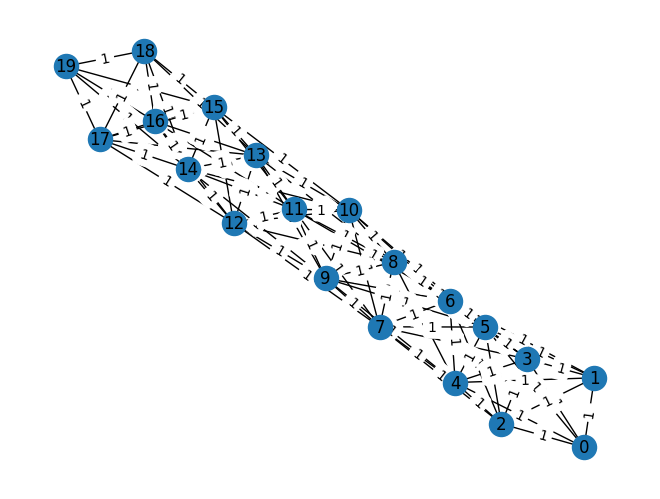

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(edge_index, edge_weight=None):
    G = nx.Graph()
    for i, (u, v) in enumerate(zip(edge_index[0], edge_index[1])):
        G.add_edge(u.item(), v.item(), weight=edge_weight[i].item() if edge_weight is not None else 1)
    
    pos = nx.spring_layout(G)
    weights = nx.get_edge_attributes(G, 'weight')
    
    nx.draw(G, pos, with_labels=True, connectionstyle='arc3,rad=0.1')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=weights)
    plt.show()

visualize_graph(edge_index)

tensor([[0.4377, 0.3885],
        [0.4342, 0.3875],
        [0.4307, 0.3865],
        [0.4272, 0.3855],
        [0.4237, 0.3845],
        [0.4202, 0.3835],
        [0.4167, 0.3825],
        [0.4132, 0.3815],
        [0.4097, 0.3805],
        [0.4062, 0.3795],
        [0.0000, 0.0000],
        [0.3993, 0.3775],
        [0.3958, 0.3765],
        [0.3923, 0.3755],
        [0.3888, 0.3745],
        [0.3853, 0.3735],
        [0.3818, 0.3725],
        [0.3783, 0.3715],
        [0.3748, 0.3705],
        [0.3713, 0.3695]])
Output from GNN: tensor([[-0.0625, -0.0221,  0.0965],
        [-0.0707, -0.0250,  0.1091],
        [-0.0734, -0.0259,  0.1132],
        [-0.0744, -0.0261,  0.1145],
        [-0.0745, -0.0260,  0.1144],
        [-0.0740, -0.0257,  0.1134],
        [-0.0718, -0.0248,  0.1098],
        [-0.0698, -0.0239,  0.1063],
        [-0.0680, -0.0231,  0.1032],
        [-0.0667, -0.0225,  0.1009],
        [-0.0660, -0.0220,  0.0994],
        [-0.0660, -0.0218,  0.0989],
        [-0.0666, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:312: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


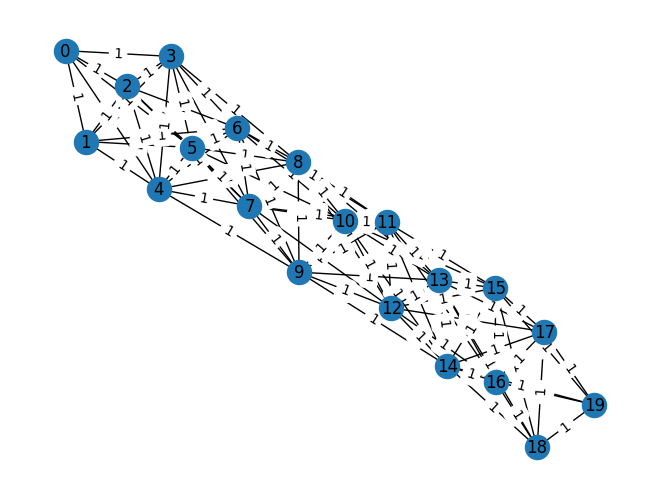

In [63]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.nn as nn

edge_index1, edge_weights1 = create_optimized_edge_index(20, 5)
model = md.EquivariantGraphNN(in_channels=2, hidden_channels=5, out_channels=3)
for src, tgt, mask in val_dataloader:
  print(src[0])
  output = model(src[0], edge_index1, edge_weights1)
  print("Output from GNN:", output)
  visualize_graph(edge_index1)
  break